# Проверка гипотез по увеличению выручки в интернет-магазине - оценить результаты A/B теста

**Задачи**: Приоритизировать гипотезы, запустить A/B-тест и проанализировать его результаты. 

**Описание данных**

Файл `/datasets/hypothesis.csv`:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл `/datasets/orders.csv`:
- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста.

## Загрузка и предобработка данных

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np
import math as mth

sns.set_palette('muted')
sns.set_style('darkgrid')
sns.despine();

<Figure size 432x288 with 0 Axes>

In [2]:
pth1_hypothesis = 'hypothesis.csv'
pth1_orders = 'orders.csv'
pth1_visitors = 'visitors.csv'

# сюда можно ввести ваш адрес к датасету
pth2_hypothesis = ''
pth2_orders = ''
pth2_visitors = ''

try:
    hypothesis = pd.read_csv(pth1_hypothesis)
    orders = pd.read_csv(pth1_orders)
    visitors = pd.read_csv(pth1_visitors)
except FileNotFoundError:
    hypothesis = pd.read_csv(pth2_hypothesis)
    orders = pd.read_csv(pth2_orders)
    visitors = pd.read_csv(pth2_visitors)
except:
    print('Something is wrong')

In [3]:
display(hypothesis.info(), orders.info(), visitors.info(), 
        hypothesis.head(), orders.head(), visitors.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   

None

None

None

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
# переведем названия столбцов  в нижний регистр
orders = orders.rename(columns = {'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})
hypothesis.columns = ['hypothesis', 'reach', 'impact', 'confidence', 'efforts']

In [5]:
# столбцы с датами приведем к типу Datetime
orders['date'] = orders['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [6]:
# проверим данные на наличие пропусков и дубликатов
display(hypothesis.duplicated().sum(), orders.duplicated().sum(), visitors.duplicated().sum(),
        hypothesis.isna().sum(), orders.isna().sum(), visitors.isna().sum())

# пропуски и дубликаты в данных отсутствуют

0

0

0

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

In [7]:
# уточним количество групп в тесте, период тестирования, количество пользователей и посетителей для каждой группы
unique_group = pd.concat([orders['group'], visitors['group']], axis=0).nunique()
date_min = str(pd.concat([orders['date'], visitors['date']], axis=0).min()).split(' ')[0]
date_max = str(pd.concat([orders['date'], visitors['date']], axis=0).max()).split(' ')[0]
duration_test = str(pd.concat([orders['date'], visitors['date']], axis=0).max() -pd.concat([orders['date'], visitors['date']],\
                                                                                axis=0).min() + timedelta(days=1)).split(' ')[0]
A_users = orders[orders['group'] == 'A']['visitor_id'].nunique()
B_users = orders[orders['group'] == 'B']['visitor_id'].nunique()
A_visitors = visitors[visitors['group'] == 'A']['visitors'].sum()
B_visitors = visitors[visitors['group'] == 'B']['visitors'].sum()

print(f"""Количество групп в тесте: {unique_group}. A и В соответственно.\n
Дата начала теста: {date_min}. Дата окончания теста: {date_max}. Продолжительность теста: {duration_test} день.\n
Количество пользователей в группе А: {A_users}. Количество пользователей в группе B: {B_users}.\n
Количество посетителей в группе А: {A_visitors}. Количество посетителей в группе B: {B_visitors}.
""")

Количество групп в тесте: 2. A и В соответственно.

Дата начала теста: 2019-08-01. Дата окончания теста: 2019-08-31. Продолжительность теста: 31 день.

Количество пользователей в группе А: 503. Количество пользователей в группе B: 586.

Количество посетителей в группе А: 18736. Количество посетителей в группе B: 18916.



In [8]:
# уточним, встречаются ли в выборке пользователи, которые попали в обе группы одновременно
slice_double_users = pd.Series(orders.groupby('visitor_id', as_index=False).agg({'group': pd.Series.nunique})\
.query('group >= 2')['visitor_id'].unique())
display(slice_double_users.count() != 0)

True

В данных присутствуют пользователи, которые попали в обе тестовые группы одновременно. Чтобы избежать искажения результатов тестирования, исключим таких пользователей из анализа.

## Приоритизация гипотез

*Формулы для расчета ICE и RICE - параметров, которые будут использоваться для приоритизации гипотез*

$$ICE = \frac{Impact * Confidence}{Efforts}$$
$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$

---

In [9]:
# рассчитаем параметр ICE для каждой гипотезы
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 1)
pd.set_option('display.max_colwidth', None)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.2
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.1
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


In [10]:
# рассчитаем параметр RICE для каждой гипотезы
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 1)
pd.set_option('display.max_colwidth', None)
display(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


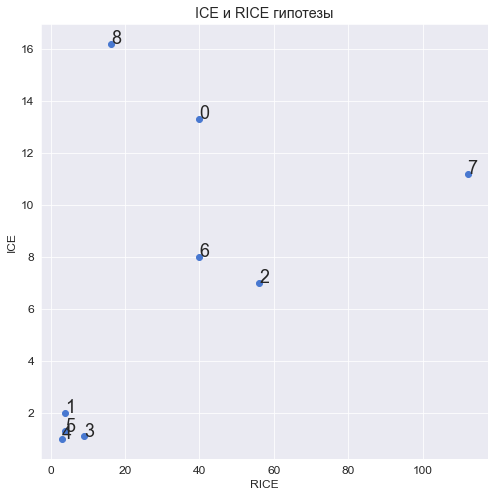

In [11]:
# построим соответствующий график 
plt.rc('font', size=12)

y = hypothesis['ICE'] 
z = hypothesis['RICE'] 
n = hypothesis.index 

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=18)

plt.title("ICE и RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE")

fig.set_figheight(8)
fig.set_figwidth(8)
plt.show()   

In [12]:
hypothesis_1 = hypothesis['hypothesis'][7]
print(f'Приоритетная гипотеза: {hypothesis_1}.')

Приоритетная гипотеза: Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.


## Анализ устойчивости кумулятивных метрик

In [13]:
# создание сводной таблицы для заказов группы А
orders_daily_A = orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
                 .groupby('date', as_index=False).agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
orders_daily_A.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

# вычисление кумулятивной выручки для группы А
orders_cummulative_A = orders_daily_A.apply(lambda x: orders_daily_A[orders_daily_A['date'] <= x['date']]\
                       .agg({'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}), axis=1)\
                       .sort_values(by=['date'])
orders_cummulative_A.columns = ['date', 'orders_сummulative_A', 'revenue_сummulative_A']

# создание сводной таблицы для заказов группы В
orders_daily_B = orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]\
                 .groupby('date', as_index=False).agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
orders_daily_B.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

# вычисление кумулятивной выручки для группы B
orders_cummulative_B = orders_daily_B.apply(lambda x: orders_daily_B[orders_daily_B['date'] <= x['date']]\
                       .agg({'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}), axis=1)\
                       .sort_values(by=['date'])
orders_cummulative_B.columns = ['date', 'orders_сummulative_B', 'revenue_сummulative_B']

# создание сводной таблицы для посетителей группы А
visitors_daily_A = visitors[visitors['group'] == 'A'][['date', 'visitors']].groupby('date', as_index=False)\
                   .agg({'visitors': 'max'})
visitors_daily_A.columns = ['date', 'visitors_per_date_A']

# вычисление кумулятивного числа посетителей для группы А
visitors_cummulative_A = visitors_daily_A.apply(lambda x: visitors_daily_A[visitors_daily_A['date'] <= x['date']]\
                         .agg({'date': 'max', 'visitors_per_date_A': 'sum'}), axis=1)
visitors_cummulative_A.columns = ['date', 'visitors_cummulative_A']

# создание сводной таблицы для посетителей группы В
visitors_daily_B = visitors[visitors['group'] == 'B'][['date', 'visitors']].groupby('date', as_index=False)\
                   .agg({'visitors': 'max'})
visitors_daily_B.columns = ['date', 'visitors_per_date_B']

# вычисление кумулятивного числа посетителей для группы B
visitors_cummulative_B = visitors_daily_B.apply(lambda x: visitors_daily_B[visitors_daily_B['date'] <= x['date']]\
                         .agg({'date': 'max', 'visitors_per_date_B': 'sum'}), axis=1)
visitors_cummulative_B.columns = ['date', 'visitors_cummulative_B']

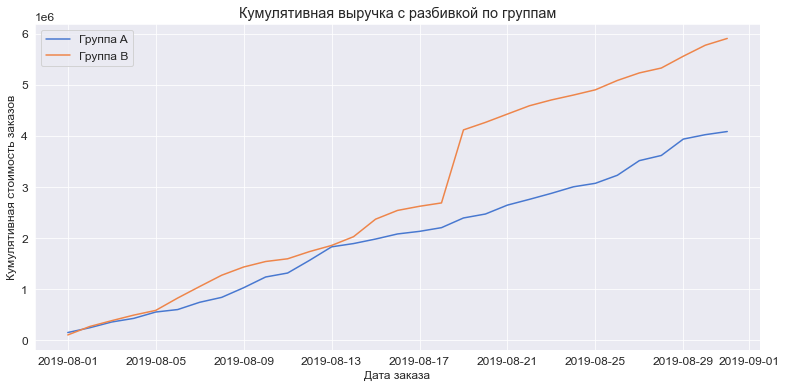

In [14]:
# построим графики кумулятивной стоимости заказов групп А и В
plt.figure(figsize=(13, 6))
plt.rc('font', size=12) 
plt.plot(orders_cummulative_A['date'], orders_cummulative_A['revenue_сummulative_A'], label='Группа A')
plt.plot(orders_cummulative_B['date'], orders_cummulative_B['revenue_сummulative_B'], label='Группа B')
plt.legend()
plt.ylabel('Кумулятивная стоимость заказов')
plt.xlabel('Дата заказа')
plt.title('Кумулятивная выручка с разбивкой по группам')

plt.show()

Кумулятивная выручка увеличивается почти равномерно. Однако, график группы В в нескольких точках резко растет. Это говорит о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

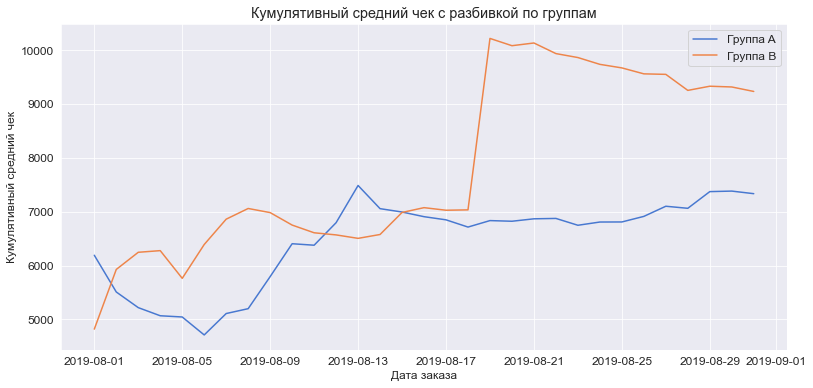

In [15]:
# построим графики кумулятивного среднего чека для групп А и В
plt.figure(figsize=(13, 6))
plt.rc('font', size=12) 
(
    plt.plot(orders_cummulative_A['date'], orders_cummulative_A['revenue_сummulative_A']/
             orders_cummulative_A['orders_сummulative_A'], label='Группа A')
)
(
    plt.plot(orders_cummulative_B['date'], orders_cummulative_B['revenue_сummulative_B']/
             orders_cummulative_B['orders_сummulative_B'], label='Группа B')
)
plt.legend()
plt.ylabel('Кумулятивный средний чек')
plt.xlabel('Дата заказа')
plt.title('Кумулятивный средний чек с разбивкой по группам')

plt.show()

В динамике кумулятивный средний чек в группе В выше, чем в группе А. В группу B во второй половине теста, скорее всего, попали крупные заказы (резкий рост на графике). 

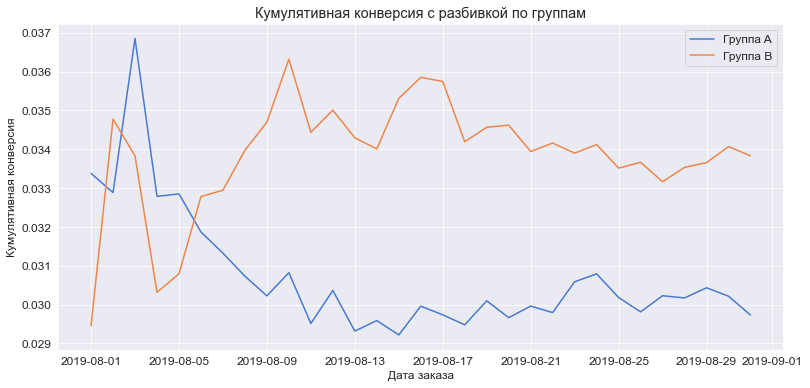

In [16]:
# построим графики кумулятивной конверсии для групп А и В
plt.figure(figsize=(13, 6))
plt.rc('font', size=12) 
(
    plt.plot(orders_cummulative_A['date'], orders_cummulative_A['orders_сummulative_A']/
             visitors_cummulative_A['visitors_cummulative_A'], label='Группа A')
)
(
    plt.plot(orders_cummulative_B['date'], orders_cummulative_B['orders_сummulative_B']/
             visitors_cummulative_B['visitors_cummulative_B'], label='Группа B')
)
plt.legend()
plt.ylabel('Кумулятивная конверсия')
plt.xlabel('Дата заказа')
plt.title('Кумулятивная конверсия с разбивкой по группам')

plt.show()

В обе группы в начале теста попали посетители с большим числом заказов (резкий рост на графике). В начале теста кумулятивная конверсия в группе А была выше, чем в группе В. В динамике же кумулятивная конверсия в группе В оказалась выше, чем в группе А. 

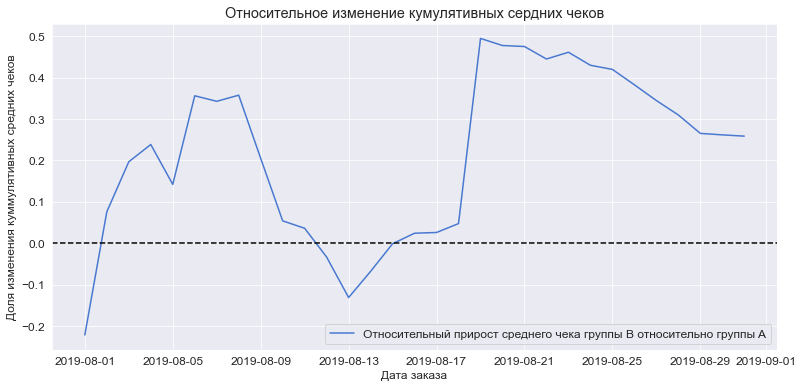

In [17]:
# cтроим график относительного изменения кумулятивных средних чеков для групп А и В
plt.figure(figsize=(13, 6))
plt.rc('font', size=12) 
(
    plt.plot(orders_cummulative_A['date'], (orders_cummulative_B['revenue_сummulative_B']/
                                            orders_cummulative_B['orders_сummulative_B'])/
             (orders_cummulative_A['revenue_сummulative_A']/orders_cummulative_A['orders_сummulative_A'])-1, 
            label='Относительный прирост среднего чека группы B относительно группы A')
)
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Доля изменения куммулятивных средних чеков')
plt.xlabel('Дата заказа')
plt.title('Относительное изменение кумулятивных сердних чеков')

plt.show()

Показатеьль кумулятивного среднего чека сильно колеблется, что говорит о наличии аномальных значений в данных. Сделать по этому графику определенные выводы невозможно.

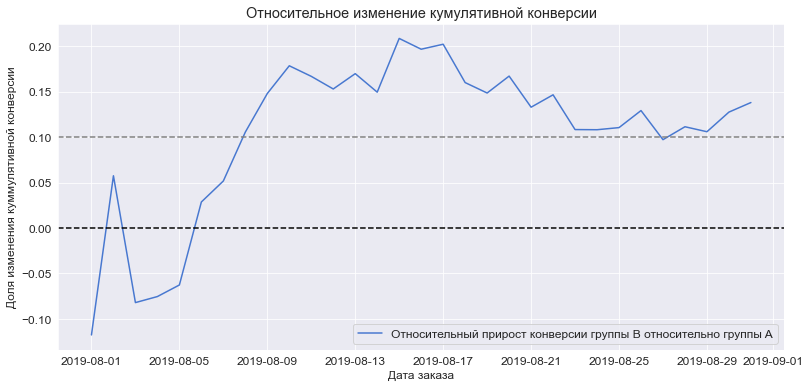

In [18]:
# cтроим график относительного изменения кумулятивной конверсии для групп А и В
plt.figure(figsize=(13, 6))
plt.rc('font', size=12) 
(
    plt.plot(orders_cummulative_A['date'], 
             (orders_cummulative_B['orders_сummulative_B']/visitors_cummulative_B['visitors_cummulative_B'])
             /(orders_cummulative_A['orders_сummulative_A']/visitors_cummulative_A['visitors_cummulative_A'])-1, 
             label='Относительный прирост конверсии группы B относительно группы A')
)
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.ylabel('Доля изменения куммулятивной конверсии')
plt.xlabel('Дата заказа')
plt.title('Относительное изменение кумулятивной конверсии')

plt.show()

Показатель кумулятивной конверсии почти установился и имеет тенденцию к росту.

## Анализ аномальных значений

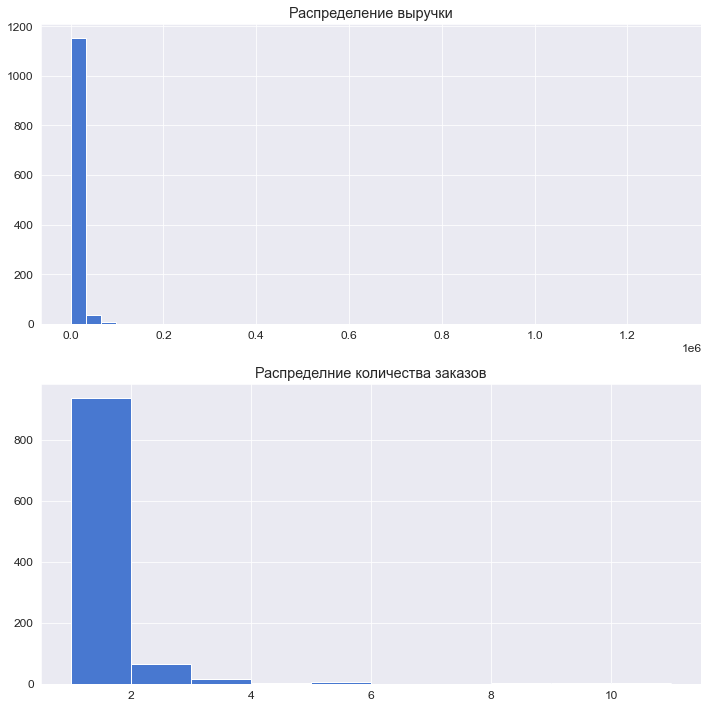

In [19]:
# оценим наличие аномальных значений
plt.figure(figsize=(10, 10))
plt.rc('font', size=12)

plt.subplot(2, 1, 1)
plt.hist(orders['revenue'], bins=40)
plt.title('Распределение выручки') 
plt.tight_layout();

plt.subplot(2, 1, 2)
plt.hist(orders[['transaction_id', 'visitor_id']].groupby('visitor_id', as_index=False)\
         .agg({'transaction_id': pd.Series.nunique})['transaction_id'], bins=10)
plt.title('Распределние количества заказов') 
plt.tight_layout(); 

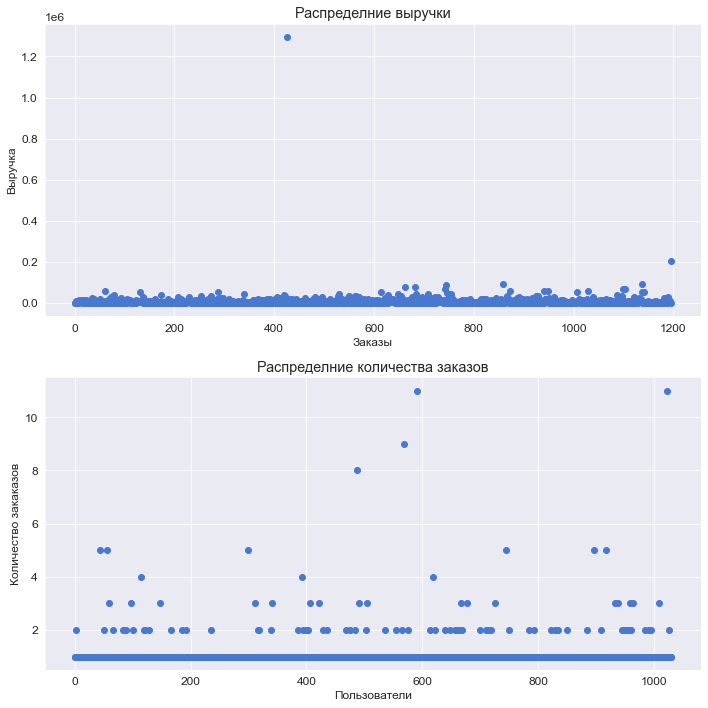

In [20]:
# в данных присутствуют аномально большие значения
# более детально рассмотрим их другим способом
plt.figure(figsize=(10, 10))
plt.rc('font', size=12) 

plt.subplot(2, 1, 1)
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.ylabel('Выручка')
plt.xlabel('Заказы')
plt.title('Распределние выручки') 
plt.tight_layout();

plt.subplot(2, 1, 2)
x_values = pd.Series(range(0,len(orders['visitor_id'].unique())))
y_values = orders[['transaction_id', 'visitor_id']].groupby('visitor_id', as_index=False)\
.agg({'transaction_id': pd.Series.nunique})['transaction_id']
plt.scatter(x_values, y_values) 
plt.ylabel('Количество закаказов')
plt.xlabel('Пользователи')
plt.title('Распределние количества заказов')
plt.tight_layout();

In [21]:
# определим 90, 95 и 99 перцентили
revenue_percentile = np.percentile(orders['revenue'], [90, 95, 99])
cnt_orders_percentile = np.percentile(orders[['transaction_id', 'visitor_id']].groupby('visitor_id', as_index=False)\
                                      .agg({'transaction_id': pd.Series.nunique})['transaction_id'],[90, 95, 99])

print(f"""90-й, 95-й и 99-й перцентили для стоимости заказов {revenue_percentile}\n
90-й, 95-й и 99-й перцентили для количества заказов {cnt_orders_percentile}""")

90-й, 95-й и 99-й перцентили для стоимости заказов [18168.  28000.  58233.2]

90-й, 95-й и 99-й перцентили для количества заказов [1. 2. 4.]


Анализ аномальных значений:

- Не более 5% заказов дороже 28 тысяч и не более 1% заказов дороже 58 тысяч.
- Не более 5% пользователей сделали заказ более 2 раз и не более 1% пользователей сделали заказ более 4 раз.

## Анализ результатов A/B теста
### Расчет по исходным данным

Определим, является ли различие в среднем количестве заказов на посетителя (конверсии) в тестовых группах А и В статистически значимым. Сформулируем гипотезы:

- H0 - Статистически значимых различий в среднем количестве заказов на пользователя между группами нет.
- Н1 - Статистически значимые различия в среднем количестве заказов на пользователя между группами есть.

Для проверки гипотез применим тест Манна-Уитни. Т.к. распределение количества заказов не является нормальным, что видно из соответствующего графика выше.

In [22]:
orders_A = orders[orders['group'] == 'A'][['transaction_id', 'visitor_id', 'revenue']]\
                 .groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
orders_A.columns = ['users_id', 'orders', 'revenue']  

orders_B = orders[orders['group'] == 'B'][['transaction_id', 'visitor_id', 'revenue']]\
                 .groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
orders_B.columns = ['users_id', 'orders', 'revenue']

sample_A = (
    pd.concat([orders_A['orders'], pd.Series(0, index=np.arange(visitors_daily_A['visitors_per_date_A'].sum()
    - len(orders_A['orders'])), name='orders')],axis=0)
)

sample_B = (
    pd.concat([orders_B['orders'], pd.Series(0, index=np.arange(visitors_daily_B['visitors_per_date_B'].sum()
    - len(orders_B['orders'])), name='orders')],axis=0)
)

alpha = 0.05

how_many_test = round((sample_B.mean() / sample_A.mean() - 1) * 100, 1)
mannwhitneyu_test = round(st.mannwhitneyu(sample_A, sample_B)[1], 5)

print(f'p-value: {mannwhitneyu_test}')

if mannwhitneyu_test < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.') 
    
print(f'На сколько % среднее количество заказов на посетителя в группе В больше, чем в группе А: {how_many_test}%')

p-value: 0.01679
Отвергаем нулевую гипотезу: разница статистически значима.
На сколько % среднее количество заказов на посетителя в группе В больше, чем в группе А: 13.8%


Вывод: По исходным данным различия в конверсии для групп A и B есть.

Определим, является ли различие в среднем чеке в тестовых группах А и В статистически значимым. Сформулируем гипотезы:

- H0 - Статистически значимых различий в среднем чеке между группами нет.
- Н1 - Статистически значимые различия в среднем чеке между группами есть.

Для проверки гипотез применим тест Манна-Уитни. Т.к. распределение выручки не является нормальным, что видно из соответствующего графика выше.

In [23]:
sample_A = orders[orders['group'] == 'A']['revenue']

sample_B = orders[orders['group'] == 'B']['revenue']

alpha = 0.05

how_many_test = round((sample_B.mean() / sample_A.mean() - 1) * 100, 1)
mannwhitneyu_test = round(st.mannwhitneyu(sample_A, sample_B)[1], 5)

print(f'p-value: {mannwhitneyu_test}')

if mannwhitneyu_test < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.') 
    
print(f'На сколько % средний чек в группе В больше, чем в группе А: {how_many_test}%')

p-value: 0.72929
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.
На сколько % средний чек в группе В больше, чем в группе А: 25.9%


Вывод: По исходным данным различий в среднем чеке для групп A и B нет.

### Расчет по очищенным данным

За аномальных пользователей примем тех, кто совершил заказ на сумму 28000 и более и тех, кто совершил 4 и более заказов. Исключим их из анализа. Также, исключи и тех, кто попал в обе тестовые группы одновременно.

In [24]:
# найдем id аномальных пользователей
var = cnt_orders_percentile[2]
slice_users_order = orders.groupby('visitor_id', as_index=False).agg({'transaction_id': pd.Series.nunique})\
.query('transaction_id >= @var')['visitor_id']

slice_users_revenue = orders[orders['revenue'] >= revenue_percentile[1]]['visitor_id']

slice_users = pd.concat([slice_users_order, slice_users_revenue, slice_double_users], axis=0).drop_duplicates().sort_values()

Определим, является ли различие в среднем количестве заказов на пользователя (конверсии) в тестовых группах А и В статистически значимым. Сформулируем гипотезы:

- H0 - Статистически значимых различий в среднем количестве заказов на пользователя между группами нет.
- Н1 - Статистически значимые различия в среднем количестве заказов на пользователя между группами есть.

Для проверки гипотез применим тест Манна-Уитни. Т.к. распределение количества заказов не является нормальным.

In [25]:
sample_A = (
    pd.concat([orders_A[np.logical_not(orders_A['users_id'].isin(slice_users))]['orders'], 
    pd.Series(0, index=np.arange(visitors_daily_A['visitors_per_date_A'].sum()
    - len(orders_A['orders'])), name='orders')],axis=0)
)

sample_B = (
    pd.concat([orders_B[np.logical_not(orders_B['users_id'].isin(slice_users))]['orders'], 
    pd.Series(0, index=np.arange(visitors_daily_B['visitors_per_date_B'].sum()
    - len(orders_B['orders'])), name='orders')],axis=0)
)

alpha = 0.05

how_many_test = round((sample_B.mean() / sample_A.mean() - 1) * 100, 1)
mannwhitneyu_test = round(st.mannwhitneyu(sample_A, sample_B)[1], 5)

print(f'p-value: {mannwhitneyu_test}')

if mannwhitneyu_test < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.') 
    
print(f'На сколько % среднее количество заказов на посетителя в группе В больше, чем в группе А: {how_many_test}%')

p-value: 0.013
Отвергаем нулевую гипотезу: разница статистически значима.
На сколько % среднее количество заказов на посетителя в группе В больше, чем в группе А: 16.2%


Вывод: По очищенным данным данным различия в конверсии для групп A и B, все также, есть. Прирост среднего числа заказов в группе B почти не изменился.

Определим, является ли различие в среднем чеке в тестовых группах А и В статистически значимым. Сформулируем гипотезы:

- H0 - Статистически значимых различий в среднем чеке между группами нет.
- Н1 - Статистически значимые различия в среднем чеке между группами есть.

Для проверки гипотез применим тест Манна-Уитни. Т.к. распределение выручки не является нормальным.

In [26]:
sample_A = orders_A[np.logical_not(orders_A['users_id'].isin(slice_users))]['revenue']

sample_B = orders_B[np.logical_not(orders_B['users_id'].isin(slice_users))]['revenue']

alpha = 0.05

how_many_test = round((sample_B.mean() / sample_A.mean() - 1) * 100, 1)
mannwhitneyu_test = round(st.mannwhitneyu(sample_A, sample_B)[1], 5)

print(f'p-value: {mannwhitneyu_test}')

if mannwhitneyu_test < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.') 
    
print(f'На сколько % средний чек в группе В больше, чем в группе А: {how_many_test}%')

p-value: 0.79038
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя.
На сколько % средний чек в группе В больше, чем в группе А: -3.9%


Вывод: По очищенным данным различий в среднем чеке для групп A и B, все также, нет. При этом прирост среднего чека в группе В стал отрицательным, т.к. мы удалили из исходных данных самые дорогие заказы.

## Выводы

### Результаты A/B теста

- Есть статистически значимое различие в конверсии между группами как по исходным данным, так и после их очистки. Коверсия в группе B выше, чем в группе А.
- Нет статистически значимого различия в среднем чеке между группами как по исходным данным, так и после их очистки. 
- График различия кумулятивной конверсии между группами говорит нам о том, что результаты группы B лучше, чем результаты группы A и имеют тенденцию к росту.
- График различия кумулятивного среднего чека между группами сильно колеблется. Сделать по этому графику определенные выводы невозможно.

По результатам тестирования группа B одержала уверенную победу.

### Рекомендации

Остановить тест, признать его успешным и перейти к проверке следующей гипотезы.